# keras与深度学习中的数学

本节介绍keras中的一些基本操作，主要通过两个方面逐渐引入这些主题：
- 通过介绍keras中对数据的处理来了解keras中的一些基本操作
  - 序列数据的操作，比如补齐，跳词等；
  - 文字数据的处理，比如文字解析和标注。这里我们将分别介绍英文文字和中文文字的处理；
  - 介绍keras中的图像数据的实时增量类ImageDataGenerator，并且展示读取其中部分函数，改造为自己所用；
    
- 更重要的是通过介绍深度学习中的数学来逐渐引入keras中的一些针对建模的操作和选项，并通过这些实例来了解一些主要的数学概念和对应的keras选项
  - 介绍激活函数，并利用keras来展示其几何特性。同学们也可以借此了解keras中如何自定义激活函数；
  - 介绍优化算法，并利用keras来展示不同优化算法的特性，同学们也可以借此也了解keras中一些类似于callback等的特定选项的用法；
  - 介绍顺序模型和范式模型的写法和基本应用，主要是让同学们了解如何根据神经网络图来翻译成代码；

我们先调入所需的库：

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import os, gc, sys
import keras
from keras.preprocessing import sequence, text, image
from keras import utils
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(15, 10)

Using TensorFlow backend.


In [2]:
plt.rcParams.keys()

KeysView(RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.avconv_args': [],
          'animation.avconv_path': 'avconv',
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.html_args': [],
          'animation.mencoder_args': [],
          'animation.mencoder_path': 'mencoder',
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'k',
          'axes.facecolor': 'w',
          'axes.formatter.limits': [-7, 7],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.form

## 首先介绍keras中的数据操作

keras中针对常见的建模数据，将数据操作归纳为三类：
- 针对序列数据的操作，包括截断，补齐等
- 针对文字数据的操作。文字数据属于序列数据的一种特殊类别，可以使用序列数据的一些方法，同时有自己的一整套方法类来方便进行处理；
- 图像数据。这里keras主要是提供了实时对数据进行各种操作，比如反转，旋转等，的方法。通过查看源代码，读者也可以自己构造自己的类似方法；

顾名思义，序列数据就是依照一定次序排列的数据，最常见的有时间序列数据，文字也是序列数据的一种，按照惯例从左到右的特定组合表达一定的意思。也有从右到左或者从上到下的一些形式。对于序列数据，keras提供了补齐，跳词和生成词样本频率表三种操作。下面分别介绍。

一般来说，在深度学习中最终操作的数据都是张量（tensor），多维矩阵的称呼。既然是多维矩阵，那么其维度的大小就是给定的。但是实际的序列数据并不是一定都是每一段都一样长。比如说，假设需要对一组股票进行建模，但是不是每个股票的上市时间都是一样的，那么如果要对整个历史数据进行建模，那么就需要补齐那些比较短的股票序列。当然这个例子比较极端，实际中做法可能不一样。另外一个常见的例子就是按照句子为单位对文字建模的时候，因为每一句话都长短不一，因此就需要对不够长度的句子进行补齐的操作。

在keras中，sequence.pad_sequence()方法对一个列表中的不同长度的列表元素按照指定长度进行补齐。下面我们来看看。这里出于简化的考虑，我们对由自然数构成的元素的列表作为对象来进行补齐操作。

In [3]:
nobjs=500
maxlen = 20
population = 100+np.arange(maxlen)
print(population)
objList = []
for i in range(nobjs):
    size = np.random.randint(1, maxlen)
    element = np.random.choice(population, size)
    objList.append(element)

[100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117
 118 119]


现在来看看这组列表元素的一些统计量，特别是长度的分布：

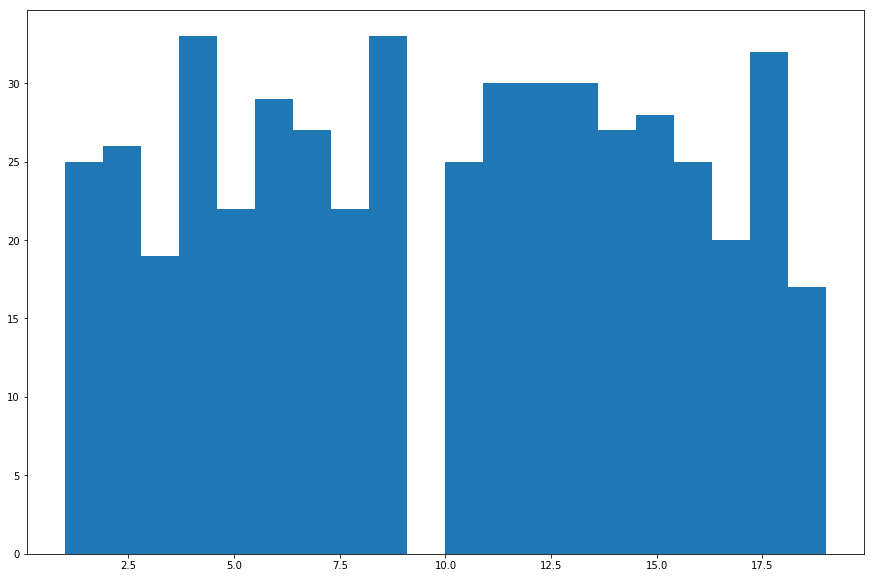

In [4]:
objLength = list(map(len, objList))
plt.hist(objLength, bins=20)
plt.show()

我们看到列表元素长度大致服从uniform分布，我们可以对这些元素按照最大长度补齐，补齐的值使用-1。这个可以用如下的命令进行：

In [5]:
pad_pre=sequence.pad_sequences(objList, maxlen=None, padding='pre', value=-1)
pad_post= sequence.pad_sequences(objList,  maxlen=10, padding='post', value=-1 )

In [6]:
for i in range(4):
    print(','.join([str(x) for x in pad_pre[i]]))

print("=================")

for i in range(4):
    print(','.join([str(x) for x in pad_post[i]]))

-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,108,108,107,111,118
-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,111,106,119,111,107,106
-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,109,103
-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,106,112,100,112,100,119
108,108,107,111,118,-1,-1,-1,-1,-1
111,106,119,111,107,106,-1,-1,-1,-1
109,103,-1,-1,-1,-1,-1,-1,-1,-1
106,112,100,112,100,119,-1,-1,-1,-1


我们看到上面的命令用-1这个值分别对前面和后面不足的部分进行补齐。同时我们看到当不指定最大长度的时候，这个方法用最长元素的长度作为补齐标准。既然能补齐，也能截断。我们看到上面有一半的元素长度超过10个字符。pad_sequences方法也有截断的选项，truncating，按照pre或者post的方法进行截断，下面展示一下：

In [7]:
trunc_pre=sequence.pad_sequences(objList, maxlen=None, truncating='pre', value=-1)
trunc_post= sequence.pad_sequences(objList,  maxlen=18, truncating='post', value=-1 )
trunc_post2= sequence.pad_sequences(objList,  maxlen=5, padding='post', truncating='post', value=-1 )

for i in range(4):
    print("长度：%s, 元素：%s" % (len(trunc_pre[i]), ','.join([str(x) for x in trunc_pre[i]])))

print("=================")

for i in range(4):
    print("长度：%s, 元素：%s" % (len(trunc_post[i]), ','.join([str(x) for x in trunc_post[i]])))
    
print("=================")

for i in range(4):
    print("长度：%s, 元素：%s" % (len(trunc_post2[i]), ','.join([str(x) for x in trunc_post2[i]])))    

长度：19, 元素：-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,108,108,107,111,118
长度：19, 元素：-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,111,106,119,111,107,106
长度：19, 元素：-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,109,103
长度：19, 元素：-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,106,112,100,112,100,119
长度：18, 元素：-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,108,108,107,111,118
长度：18, 元素：-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,111,106,119,111,107,106
长度：18, 元素：-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,109,103
长度：18, 元素：-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,106,112,100,112,100,119
长度：5, 元素：108,108,107,111,118
长度：5, 元素：111,106,119,111,107
长度：5, 元素：109,103,-1,-1,-1
长度：5, 元素：106,112,100,112,100


我们看到，当使用截断的时候，
- 首先，如果不指定长度，那么根据pre或者post的选项值，只截掉第一个或者最后一个元素；
- 其次，如果元素长度达不到截断指定的长度，那么会用value=选项的值进行填充，填充位置是按照padding选项的值来定。

下面再来看看另外一个序列数据的处理方法：skipgrams。skipgrams是NLP里常用的跳词法，是word2vec这个嵌入方法的基础，是在对话里用来构造训练数据的一个有效方法。

其作用对象是一组整数的列表，因为在最后处理NLP的问题时，文字和单词都会转换成通常是自然数的索引标号。

其作用的手段是根据一个随机数生成器（下面详解）对于列表里的元素的产生指定数目的两两组合，这两个元素是在原数据集上存在于指定的窗口区间内的，标注为1，即所谓的正样本；然后产生同样多组的随机组合，是给定词和窗口区间外词的组合，作为负样本。

下面我们看看实例加强理解。

我们对上面随机产生的第二个列表进行操作。

In [8]:
x = [0, 1, 2, 3, 4, 5, 6, 7]
print(x)
pos, neg = 0, 0
result=sequence.skipgrams(x, vocabulary_size=3, window_size=4, shuffle=False)
for i in range(len(result[0])):
    print("Label=%s, value=%s" % (result[1][i], result[0][i]))
    if result[1][i]==0:
        neg += 1
    else:
        pos += 1
        
print(pos, neg)        

[0, 1, 2, 3, 4, 5, 6, 7]
Label=1, value=[1, 2]
Label=1, value=[1, 3]
Label=1, value=[1, 4]
Label=1, value=[1, 5]
Label=1, value=[2, 1]
Label=1, value=[2, 3]
Label=1, value=[2, 4]
Label=1, value=[2, 5]
Label=1, value=[2, 6]
Label=1, value=[3, 1]
Label=1, value=[3, 2]
Label=1, value=[3, 4]
Label=1, value=[3, 5]
Label=1, value=[3, 6]
Label=1, value=[3, 7]
Label=1, value=[4, 1]
Label=1, value=[4, 2]
Label=1, value=[4, 3]
Label=1, value=[4, 5]
Label=1, value=[4, 6]
Label=1, value=[4, 7]
Label=1, value=[5, 1]
Label=1, value=[5, 2]
Label=1, value=[5, 3]
Label=1, value=[5, 4]
Label=1, value=[5, 6]
Label=1, value=[5, 7]
Label=1, value=[6, 2]
Label=1, value=[6, 3]
Label=1, value=[6, 4]
Label=1, value=[6, 5]
Label=1, value=[6, 7]
Label=1, value=[7, 3]
Label=1, value=[7, 4]
Label=1, value=[7, 5]
Label=1, value=[7, 6]
Label=0, value=[2, 1]
Label=0, value=[6, 1]
Label=0, value=[7, 1]
Label=0, value=[6, 2]
Label=0, value=[3, 2]
Label=0, value=[3, 2]
Label=0, value=[4, 1]
Label=0, value=[5, 2]
Label=0

In [9]:
sequence.make_sampling_table(3)

array([ 0.00315225,  0.00315225,  0.00547597])

随机取样的概率按照如下公式进行：

$$
 p(word) = \min \left(1, \left( \frac{word.frequency}{sampling_factor} \right) \big{/} \sqrt{\frac{word.frequency}{sampling_factor}} \right)
$$ 

## 文本数据的处理

文本数据的处理主要是在解析和标注上，根据需要操作的对象不同，方法也有不同。这里我们按照文字分为英文和中文两种；同时按照输入数据是单一文件还是多个文件分为两种情况。因为这两类情景相互独立，因此我们分别介绍。

首先我们介绍英文单一文本的处理。对于英文的单一文本，keras提供了text_to_word_sequence这个函数，可以将字符串类型一句话分裂为单词。听起来简单，但是在实际操作中有很多选项会产生完全不同的结果。下面演示一下。

In [10]:
input="Keras is a high-level neural networks API, written in Python and capable of running on top of TensorFlow, \
       CNTK, or Theano."
filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
result = text.text_to_word_sequence(input,
                                    filters='a',
                                    lower=True,
                                    split=" ")
print(result)

['ker', 's', 'is', 'high-level', 'neur', 'l', 'networks', 'pi,', 'written', 'in', 'python', 'nd', 'c', 'p', 'ble', 'of', 'running', 'on', 'top', 'of', 'tensorflow,', 'cntk,', 'or', 'the', 'no.']


这个方法里，lower选项就是指将输入的字符转换成小写字符处理并输出，只对英文有效。这里需要详细讲讲filters和split这两个选项：
- filters 这个选项对一个列表里的字符进行过滤，就是在这个列表里的字符都会被过滤掉。这里中英文字符都可以放入过滤字符列表中起作用，下面的例子做了展示；
- split 这个选项对句子的解析至关重要。输入要求是一个字符串，这个方法使用该字符串对输入的长字符串进行切分。在英文中使用空格符就好，但是在中文这种没有分隔符的语言中就不行，需要使用中文的专用切分工具，比如jieba等来处理。同学们也可以先使用该方法的过滤器对中英文字符进行过滤后再应用jieba分词工具。

在Anaconda环境下安装jieba，特别是在Python3的环境下安装jieba3k这个针对Python 3.x环境的分词包，可以使用如下命令：
<code>
conda install -c conda-forge jieba3k 
</code>

In [11]:
input="Keras是一个高度抽象的神经网络API，以Python写成，可以TensorFlow，CNTK或者Theano为计算后台运行"
filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\nABCDEFGHIJKLMENOPQRSTUVWXYZ行'
result = text.text_to_word_sequence(input,
                                    filters=filters,
                                    lower=False,
                                    split=",")
print(result)

['eras是一个高度抽象的神经网络', '，以', 'ython写成，可以', 'ensor', 'low，', '或者', 'heano为计算后台运']


可以看到keras的工具是为英文设计的，不能正常解析中文文本。这里我们简要介绍如何使用结巴分词来进行操作。

根据jieba分词库的自我介绍，其支持三种分词模式：
- 精确模式，试图将句子最精确地切开，适合文本分析，也是最常用的。该模式对应jieba.cut方法，使用cut_all=False选项
- 全模式，把句子中所有的可以成词的词语都扫描出来, 速度非常快而且颗粒度非常高，但是不能解决歧义，比如“...川普通过...”会被切分为“川普”，“普通”等多个词，但是这里实际上只有“川普”这个词有意义。该模式也对应jieba.cut方法，使用cut_all=True选项
- 搜索引擎模式，在精确模式的基础上，对长词再次切分，提高召回率，适合用于搜索引擎分词。该模式对应jieba.cut_for_search方法。

在jieba3k中，以上两种方法都返回一个可迭代的生成器（generator）对象，可以使用for 循环来获取分割后的单词。

在老版本的jieba.cut和jieba.cut_for_search各自对应一个返回列表的函数，分别是lcut 和lcut_for_search，其用法一样，只是返回数据类型是一个列表，但是在jieba3k中似乎没有这些方法了。

In [12]:
import jieba

In [13]:
chn='此开卷第一回也。作者自云：因曾历过一番梦幻之后，故将真事隐去，而借"通灵 \
"之说，撰此《石头记》一书也。故曰"甄士隐"云云．但书中所记何事何人？自又 \
云：“今风尘碌碌，一事无成，忽念及当日所有之女子，一一细考较去，觉其行止见 \
识，皆出于我之上．何我堂堂须眉，诚不若彼裙钗哉？实愧则有余，悔又无益之大无可 \
如何之日也！当此，则自欲将已往所赖天恩祖德，锦衣纨绔之时，饫甘餍肥之日，背父 \
兄教育之恩，负师友规谈之德，以至今日一技无成，半生潦倒之罪，编述一集，以告天 \
下人：我之罪固不免，然闺阁中本自历历有人，万不可因我之不肖，自护己短，一并使 \
其泯灭也．虽今日之茅椽蓬牖，瓦灶绳床，其晨夕风露，阶柳庭花，亦未有妨我之襟怀 \
笔墨者．虽我未学，下笔无文，又何妨用假语村言，敷演出一段故事来，亦可使闺阁昭 \
传，复可悦世之目，破人愁闷，不亦宜乎？故曰"贾雨村"云云。'

chnout1 = jieba.cut(chn, cut_all=False)
chnoutlist1 = [x for x in chnout1]
print(len(chnoutlist1), [x for x in chnoutlist1[:15]])

chnout2 = jieba.cut(chn, cut_all=True)
chnoutlist2 = [x for x in chnout2]
print(len(chnoutlist2), [x for x in chnoutlist2[:25]])

chnout3 = jieba.cut(chn, cut_all=True, HMM=True)
chnoutlist3 = [x for x in chnout3]
print(len(chnoutlist3), [x for x in chnoutlist3[35:50]])

chnout4 = jieba.cut_for_search(chn, HMM=False)
chnoutlist4 = [x for x in chnout4]
print(len(chnoutlist3), [x for x in chnoutlist3[35:50]])

Building prefix dict from D:\Anaconda3\lib\site-packages\jieba\dict.txt ...
Loading model from cache C:\Users\xieliang\AppData\Local\Temp\jieba.cache
Loading model cost 0.8281905651092529 seconds.
Prefix dict has been built succesfully.


248 ['此', '开卷', '第一回', '也', '。', '作者', '自云', '：', '因曾', '历过', '一番', '梦幻', '之后', '，', '故']
361 ['此', '开卷', '第一', '第一回', '一回', '也', '', '', '作者', '自', '云', '', '', '因', '曾', '历', '过', '一番', '梦幻', '之后', '', '', '故', '将', '真事']
361 ['', '', '之说', '', '', '撰', '此', '', '', '石头', '石头记', '', '', '一', '书']
361 ['', '', '之说', '', '', '撰', '此', '', '', '石头', '石头记', '', '', '一', '书']


对于大批量的文本文件，当需要同意进行处理的时候，keras提供了一个非常方便的类称为：Tokenizer，可以对多个文档以列表元素形式存在的对象进行统一操作。这个方法一般应用在一次性批量读入多个文本文件以后，提供的方法有：
- fit_on_texts(texts)。该方法对于一个文本列表进行拟合，拟合的目的是为了获得以下的关键统计量：
- texts_to_sequences(texts)，同时有个与生成器对象对应的texts_to_sequences_generator(texts)方法；
- texts_to_matrix(texts);
- fit_on_sequences(sequences)
- sequences_to_matrix(sequences)

下面我们来看看实例，该实例来自于keras的官方博客。

In [14]:
%%time

TEXT_DATA_DIR = './data/20_newsgroup'
texts = []  # 用于存储文本的列表
labels_index = {}  # 子目录列表词典，因为每个子目录都是一类对应的文字，所以被称为label
labels = []  # list of label ids
for name in sorted(os.listdir(TEXT_DATA_DIR)):  # 按照路径名排序读入文件夹下的所有子目录
    path = os.path.join(TEXT_DATA_DIR, name)    # 构造完整的路径名
    if os.path.isdir(path):                     # 如果是一个存在的文件夹
        label_id = len(labels_index)
        labels_index[name] = label_id
        for fname in sorted(os.listdir(path)):   #按照文件名依次读入文件夹下所有文本文件
            if fname.isdigit():                  # 属于这个邮件组的文件都已数字命名
                fpath = os.path.join(path, fname) # 构造完整文件路径名
                if sys.version_info < (3,):
                    f = open(fpath)
                else:
                    f = open(fpath, encoding='latin-1')
                t = f.read()                      # 一次性读入整个文本文件
                i = t.find('\n\n')  # skip header
                if 0 < i:
                    t = t[i:]
                texts.append(t)
                f.close()
                labels.append(label_id)

print('Found %s texts.' % len(texts))

Found 19997 texts.
Wall time: 1min 4s


In [15]:
t

"\n\nIn article <C64H4w.BFH@darkside.osrhe.uoknor.edu> \nbil@okcforum.osrhe.edu (Bill Conner) writes:\n>Keith M. Ryan (kmr4@po.CWRU.edu) wrote:\n>: And now . . . Deep Thoughts\n>: \tby Jack Handey.\n>: If you go parachuting, and your parachute doesn't open, and your\n>: friends are all watching you fall, I think a funny gag would be\n>: to pretend you were swimming.\n>Keith, \n>As you must know by now there are no Escape Sequences here (ANSI or\n>otherwise). Once you enter here, your terminal beomes dumb. There's\n>something significant about all this ...\n\nYou are in the village. Many happy returns! Be seeing you!\n\n[your ways and means get reign of the tek!]\n"

下面对所有接近2万个文本进行批量的包括补齐等的操作

In [16]:
MAX_NB_WORDS= 10 # 该选项如果设定为一个整数，那么Tokenizer只输出前N个最常见的单词的相关信息
MAX_SEQUENCE_LENGTH = 50  #最长句子长度，可以为中位值或者其他合适的值。

tokenizer = text.Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

In [17]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = sequence.pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = utils.to_categorical(np.asarray(labels))

print(np.max(sequences))

Found 174074 unique tokens.
[9, 9, 9, 9, 6, 4, 4, 9, 5, 3, 5, 7, 2, 9, 3, 5, 9, 9, 2, 3, 7, 3, 5, 7, 1, 2]


In [18]:
print(data[:3])
print(labels)

[[1 3 5 2 1 3 1 5 1 3 1 3 1 3 5 1 8 4 2 5 5 1 3 4 3 5 2 1 5 3 1 3 5 4 3 5 5
  3 1 3 1 4 3 5 4 3 5 2 5 4]
 [3 2 2 9 2 3 6 1 8 3 4 8 4 3 1 3 4 8 4 3 1 3 8 1 3 1 4 3 2 6 8 2 3 2 3 2 2
  8 1 3 1 2 2 2 5 5 2 1 2 2]
 [6 6 2 9 1 8 9 1 2 1 8 3 5 8 1 8 3 1 5 4 1 4 3 2 1 1 2 6 1 8 9 3 1 1 8 5 2
  4 3 1 3 6 1 3 5 8 9 2 4 3]]
[[ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  1.]
 [ 0.  0.  0. ...,  0.  0.  1.]
 [ 0.  0.  0. ...,  0.  0.  1.]]


## 图像处理方法

keras里面主要提供了一个叫ImageDataGenerator的生成器类来进行实时图像变换,这个生成器会按照批量大小在原有数据上无限循环。因为图像数据通常数据量比较大，因此使用生成器是一个很自然的选择，不会一下子把内存塞满。这个类在定义数据特征的标准化之外还定义了不同的图像变换方法，比如旋转，切割，平移等。生成器的一个潜在问题是数据在CPU和GPU之间要进行大量交换，因此IO是一个瓶颈，特别是在数据生成以后需要进行超参或网络结构调优的时候。如果资源够用的情况下，可以把其中的代码移植出来直接生成静态数据供模型使用。下面我们分别来看看：
- 如何使用这个生成器 
   - 生成器的选项 ：旋转，左右、上下平移，左右、上下翻转
   - 生成器的方法 ： flow, fit
   
- 如何把生成器中的代码一直出来直接生成静态数据

In [19]:
from keras.datasets import cifar10
datagen = image.ImageDataGenerator(    
    rotation_range=0, # 随机旋转的最大度数.    
    width_shift_range=0.1, # 水平平移的比率
    height_shift_range=0.1, # 上下平移的比率
    horizontal_flip=True, # 随机进行水平翻转
    vertical_flip=False)  # 随机上下翻转

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

out2 = datagen.flow(x_train, y_train)

我们从下面的例子中可以看到，ImageDataGenerator对象使用flow()方法，每次按照指定的批量数（这里是32个的小批量数）生成数据流。该数据流会按照上面定义的变换形式进行**随机**变换。如果放入两个对象到flow()方法，会输出一个tuple，tuple的第一个元素是前一个对象的数据流，第二个元素是后一个对象的对应数据流。

如果使用了数据生成器，那么在keras里对模型进行拟合的时候需要使用fit_generator()方法，而不能直接使用fit()方法。

(32, 32, 32, 3)
truck


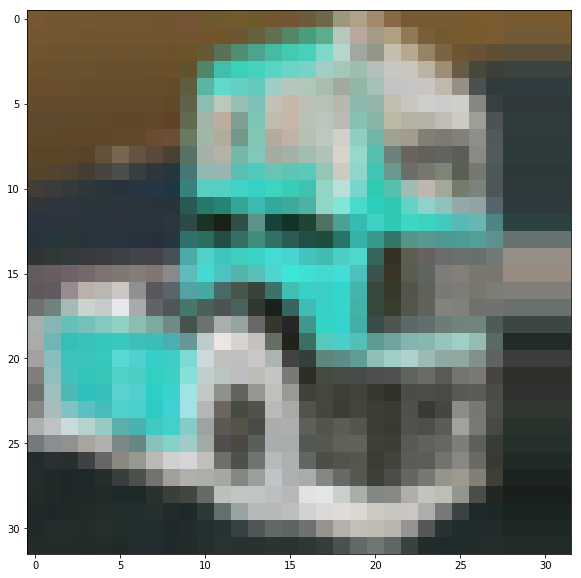

In [20]:
count=0
label_names =['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for elements in out2:
    count += 1
    if count<=1:
        img = elements[0][1]
        label = int(elements[1][1])
        print(elements[0].shape)
        print( label_names[label] )
        plt.imshow(img[:, :, :])
    else:
        break

选项也可以通过一个字典输入到ImageDataGenerator对象中：

In [21]:
# we create two instances with the same arguments
data_gen_args = dict(
                     rotation_range=0, # 随机旋转的最大度数.    
                     width_shift_range=0.1, # 水平平移的比率
                     height_shift_range=0.1, # 上下平移的比率
                     horizontal_flip=True, # 随机进行水平翻转
                     vertical_flip=False  # 随机上下翻转
                     )  
datagen = image.ImageDataGenerator(**data_gen_args)
out3 = datagen.flow(x_train, y_train)

keras的好处是他是使用Python编写，因此我们可以借鉴其源代码为我所用。比如，考虑到使用数据生成器会增加数据IO，我们准备提前对图片进行随机的上下和左右翻转，并且和原来的数据进行合并，然后一并纳入训练中。这个可以很容易地借鉴ImageDataGenerator里的源代码来实现。其翻转的源代码是（左右还是上下只取决于轴axis）：

<code>
def flip_axis(x, axis):
    x = np.asarray(x).swapaxes(axis, 0)
    x = x[::-1, ...]
    x = x.swapaxes(0, axis)
    return x
</code>    

那么我们可以直接使用这些函数来对图片数据进行操作。我们依然使用前面的<code>elements[0][1]</code>这张图片来操作。如果是水平翻转，我们沿着第2根轴进行；如果是上下翻转，我们沿着第1根轴进行。

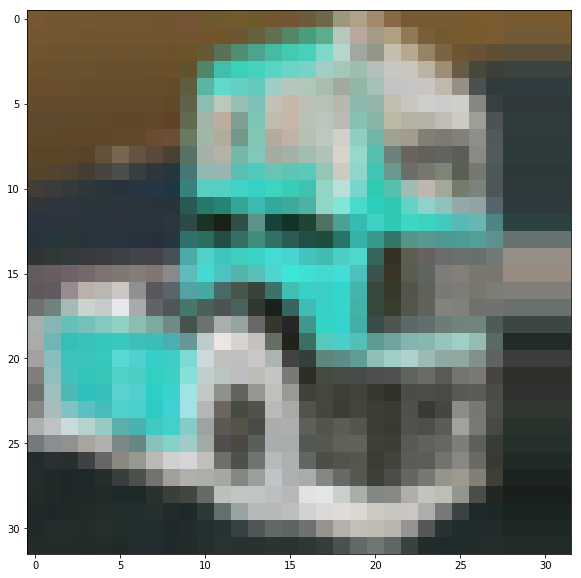

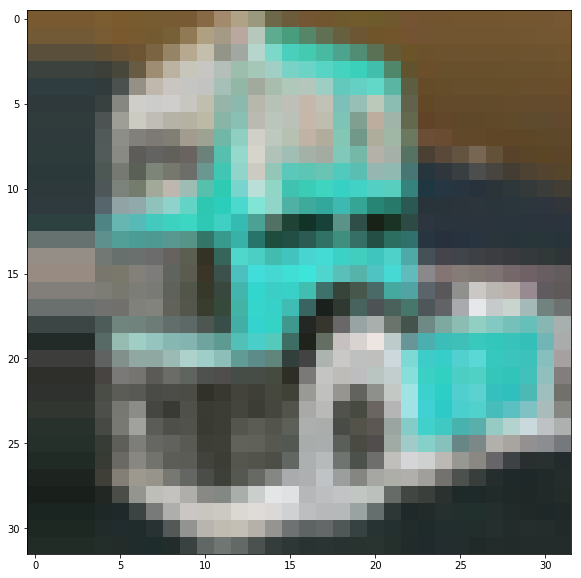

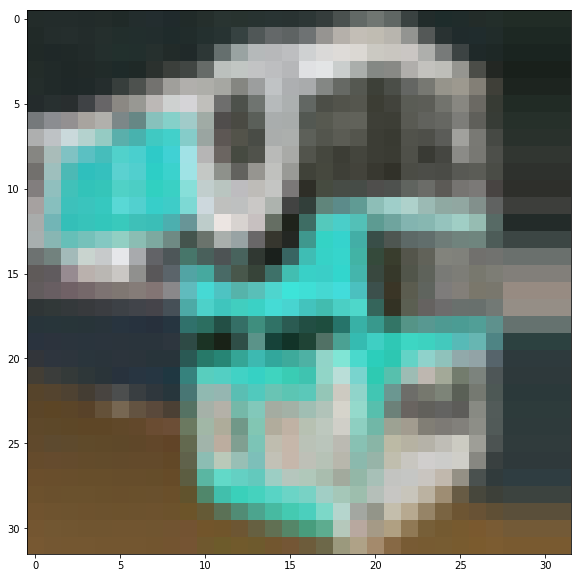

In [22]:
img_horizontal_flip = image.flip_axis(img, 1)
img_vertical_flip = image.flip_axis(img, 0)

plt.imshow(img); plt.show()
plt.imshow(img_horizontal_flip); plt.show()
plt.imshow(img_vertical_flip); plt.show()

那么如何自己生成自己所需的任意的data generator呢？这里给大家一个模板。其基本规则就是对于输入的数据源按照一定的规则进行处理，并且立即通过yield方法将产生的批量数据以tuple的形式输出。因为必须以tuple形式输出，因此如果只输出一个元素，需要以逗号“,”结尾。

In [23]:
def data_gen(X, y, batch_size=32):
    # some necessary pre-processing goes here, such as read a file, or generate shuffle index
    number_of_batches = X.shape[0]//batch_size
    counter=0
    shuffle_index = np.arange(np.shape(y)[0])
    np.random.shuffle(shuffle_index)
    while 1:   # 需要一个永续循环
        index_batch = shuffle_index[batch_size*counter:batch_size*(counter+1)]
        X_batch = (X[index_batch,:,:]).astype('float32')
        y_batch = (y[index_batch,:]).astype('float32')
        counter += 1
        yield(np.array(X_batch), y_batch)
        if (counter < number_of_batches):
            np.random.shuffle(shuffle_index)
            counter=0

# keras中的关键数学概念

在这里我们为同学们详细探讨一下keras中的一些关键数学概念。这里不拘泥于纯理论探讨，而是希望将这些数学概念与keras中的选项联系起来，主要讲解那些适合进行模型调优和理解的部分。因此，这里我们主要进行一下讨论工作：
1. 基本的神经网络概念
2. 激活函数 : activation= / Activation()
3. 优化引擎 ： optimizer
4. 网络合并

神经网络模型中有很多复杂的概念，但是从写代码的角度而言，我认为主要认识如下概念：
1. 组合函数
2. 输入特征和输入层的关系
3. 激活函数
4. 网络结构

每一个神经网络的神经元都是一组输入的线性组合后应用非线性的激活函数的结果。通常一个神经元表述为：
![神经元](./images/NNcomponents.png)

这里的$X$不一定指代原始输入层的数据，可能是上一个隐藏层的输出:

$$
   o = g(W'X + b)
$$

而整个神经网络是一个嵌套的过程：
$$
   f^0 = x \\
   f^1 = g_1(W^0f^0 + b^0)  \\
   f^2 = g_2(W^1f^1 + b^1)  \\
   \cdots                        \\
   f^{N-1} = g_{N-1}(W^{N-2} f^{N-2} + b^{N-2})  \\
   f^N = g_N(W^{N-1} f^{N-1} + b^{N-1})
$$

可以把每一次嵌套都当作在当前输出之后新的一层运算，那么就可以很自然地联系到顺序结构的网络，如下图所示：
![顺序神经网络](./images/NNstructure.png)

了解了这些基本情况之后，我们来看看更加实际的一些概念：
- 激活函数，就是上面公式里的$g_k$
- 不同优化算法的一些情况

## 激活函数

神经网络之所以强大，与其采用非线性的激活函数不无关系。在这里，我们试图通过运用keras来展示和分析激活函数从而让同学们同时了解keras的一些奇妙用法。
1. 首先，我们采用keras来生成不同激活函数的表达，并以图形的形式展示出来。
2. 然后，我们通过分析keras的源代码来演示如何生成自己自定义的激活函数。

In [24]:
from keras.layers import Dense, Activation
from keras.models import Sequential

In [25]:
x = (np.arange(100)-50)/100
y = np.log(x+51)

model = Sequential()
model.add(Dense(1, input_shape=(1,), activation='relu'))
model.add(Dense(1, activation='linear'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 2         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 2         
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


In [26]:
model.compile(loss='mse', optimizer='adam', metrics=['mse'])
model.fit(x, x, epochs=1, batch_size=128, verbose=1)

Epoch 1/1
100/100 [==============================] - 2s 20ms/step - loss: 0.0893 - mean_squared_error: 0.0893


In [27]:
from keras import backend as K

inp = model.input                                           # 输入
outputs = [layer.output for layer in model.layers]          # 抓取各个网络层，实际这里最关键的只有激活层
functions = [K.function([inp], [out]) for out in outputs]    # K.function()使用tenforflow后台初始化一个计算函数

# Testing
activationLayer={}
for i in range(x.shape[0]):
    test = x[i].reshape(-1, 1)
    layer_outs = [func([test]) for func in functions]
    #activationLayer[i] = np.reshape(layer_outs[0], (-1, 1))   
    activationLayer[i] = layer_outs[0][0][0][0]
    

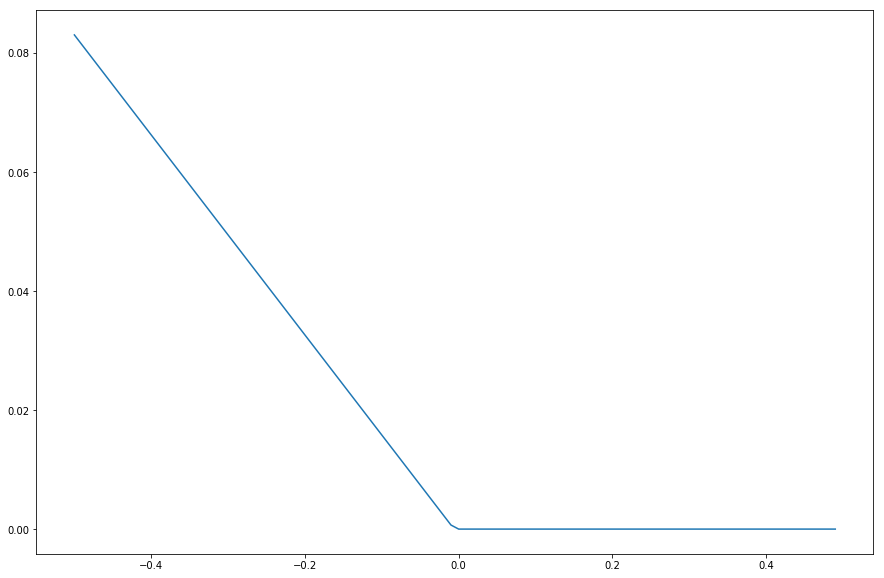

In [28]:
activationDf = pd.DataFrame.from_dict(activationLayer, orient='index')
plt.plot(x, activationDf)

因此我们可以使用这个技术来图示各种激活函数的特性。为了方便操作，下面定义函数：

In [29]:
def VisualActivation(activationFunc='relu', plot=True):
    x = (np.arange(100)-50)/10
    y = np.log(x+51)
    model = Sequential()
    model.add(Dense(1, input_shape=(1,), activation=activationFunc))
        
    model.add(Dense(1, activation='linear'))
    #model.summary()
    model.compile(loss='mse', optimizer='adagrad', metrics=['mse'])
    model.fit(x, x, epochs=1, batch_size=128, verbose=0)
    
    inp = model.input                                          
    outputs = [layer.output for layer in model.layers]     
    functions = [K.function([inp], [out]) for out in outputs]   
    
    activationLayer={}
    for i in range(100):
        test = x[i].reshape(-1, 1)
        layer_outs = [func([test]) for func in functions]
        activationLayer[i] = layer_outs[0][0][0][0]
        
    activationDf = pd.DataFrame.from_dict(activationLayer, orient='index')
    result=pd.concat([pd.DataFrame(x), activationDf], axis=1)
    result.columns=['X', 'Activated']
    result.set_index('X', inplace=True)
    if plot:
        result.plot(title=f)
    
    return result


下面来看看几种常见的激活函数：<code> sigmoid, tanh, hard_sigmoid, softplus, selu, elu </code>

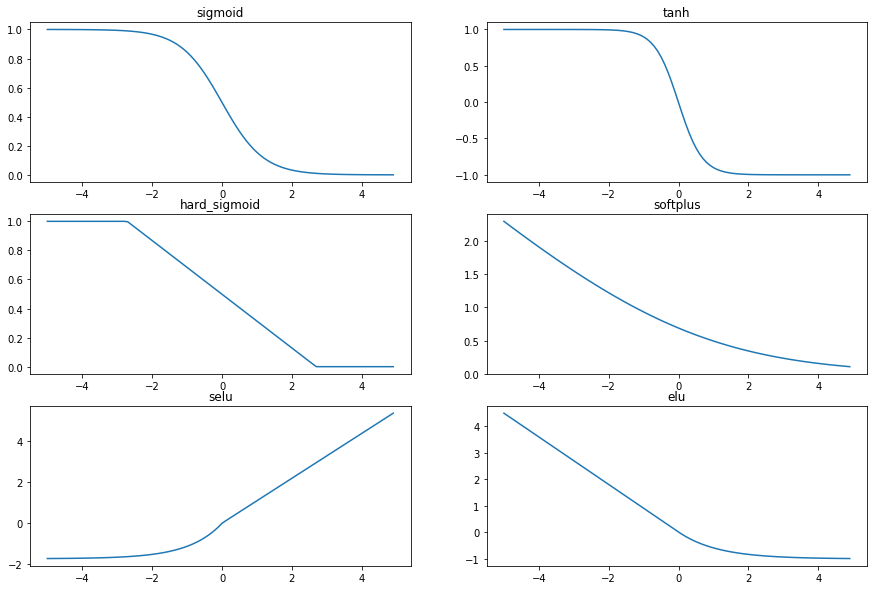

In [30]:
actFuncs = ['sigmoid', 'tanh', 'hard_sigmoid', 'softplus', 'selu', 'elu']

from keras.layers import LeakyReLU
figure = plt.figure()
for i, f in enumerate(actFuncs):
    figure.add_subplot(3, 2, i+1)
    out=VisualActivation(activationFunc=f, plot=False)
    plt.plot(out.index, out.Activated)
    plt.title(f)


同学们可以根据这个现有的简单函数自己试试别的更复杂的情况，感受一下不同激活函数的效能。

## 优化引擎

在深度学习中另外一个大家常问的问题就是关于优化引擎，就是model.compile(optimizer=)这一项。大家都知道keras提供了好几个不同的优化引擎，包括<code>sgd, adam, adagrad, RMSprop</code>等，同时很多人问过不同的优化引擎到底适合什么样的问题。下面这一节我们就来大概讲讲这几种优化引擎的差异，并通过图形化的方式来展示其特点。为了让同学们熟悉keras，这里我们也使用keras来构造计算基础，而不是像外面的很多博客或者范例一样直接使用矩阵运算暴力攻击。这不是说那样不对，而是我们的目的不同，毕竟在实际使用keras的时候一般也不会直接进行矩阵运算，keras的目的也是为了让建模的分析师脱离矩阵运算的细节，而把精力放在构造模型上。

深度学习算法里，目前的优化算法大部分都给予梯度递减或者其变形。在实际工作中，梯度递减算法的实际实施是通过SGD的各种变形来的，变形的主要焦点在于每一步的update的步长。下面仔细观察每一个算法。

### SGD
![SGDstd](./images/SGD.png)

### SGD with momentum
![SGDmomentum](./images/SGDmomentum.png)

### Nesterov
![Netserov](./images/Nesterov.png)
![SGDnetserov](./images/SGDnetserov.png)

### AdaGrad
![AdaGrap](./images/Adagrad.png)

### RMSprop
![RMSprop](./images/RMSprop.png)

该图来自于 [这个网址](http://cs231n.github.io/neural-networks-3/)

![优化路径](./images/contours_evaluation_optimizers.gif)

我们下面试图使用keras去构造类似的求解路径图。

In [31]:
import matplotlib.pyplot as plt
import autograd.numpy as np

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
from matplotlib import animation
from IPython.display import HTML

from autograd import elementwise_grad, value_and_grad
from scipy.optimize import minimize
from collections import defaultdict
from itertools import zip_longest
from functools import partial

我们的计划是这样的：
1. 先拟合一个双输入变量的多层感知器式神经网络
2. 通过model.evaluate()获取损失函数

In [32]:
xmin, xmax, xstep = -4, 4, 0.1
ymin, ymax, ystep = -4 ,4, 0.1
x, y = np.meshgrid( np.arange(xmin, xmax+xstep, xstep), np.arange(ymin, ymax+ystep, ystep))

In [34]:
from keras.layers import Input, Dense
from keras.models import Model

input = Input(shape=[2])
probs = Dense(1, activation='sigmoid')(input)

model = Model(inputs=input, outputs=probs)
model.compile(optimizer='sgd', loss='binary_crossentropy')

In [47]:
weights = model.trainable_weights
for w in weights:
    print(w.name)

wgt = [w for w in weights]
print(wgt)

t = model.get_layer(w.name.split("/")[0])

dense_16/kernel:0
dense_16/bias:0
[<tf.Variable 'dense_16/kernel:0' shape=(2, 1) dtype=float32_ref>, <tf.Variable 'dense_16/bias:0' shape=(1,) dtype=float32_ref>]


In [78]:
weights = model.trainable_weights 
weights = [weight for weight in weights if model.get_layer(weight.name.split("/")[0]).trainable] 
gradients = model.optimizer.get_gradients(model.total_loss, weights) # gradient tensors

print(gradients)

for w in weights:
    print(w.name)


[<tf.Tensor 'gradients_4/dense_16/MatMul_grad/MatMul_1:0' shape=(2, 1) dtype=float32>, <tf.Tensor 'gradients_4/dense_16/BiasAdd_grad/BiasAddGrad:0' shape=(1,) dtype=float32>]
dense_16/kernel:0
dense_16/bias:0


In [63]:
import keras.backend as K

input_tensors = [model.inputs[0], # input data
                 model.sample_weights[0], # how much to weight each sample by
                 model.targets[0], # labels
                 K.learning_phase(), # train or test mode
                 ]

get_gradients = K.function(inputs=input_tensors, outputs=gradients)

In [77]:
from keras.utils.np_utils import to_categorical

inputs = [[[1, 2]], # X
          [1], # sample weights
          [[1]], # y
          0 # learning phase in TEST mode
]

zipped = zip(weights, get_gradients(inputs))
for z in zipped:
    print("layer name %s: ; Graident value : %s" % (z[0].name, z[1]))

print("=================")
print(model.targets)

layer name dense_16/kernel:0: ; Graident value : [[-0.94366163]
 [-1.88732326]]
layer name dense_16/bias:0: ; Graident value : [-0.94366163]
[<tf.Tensor 'dense_16_target:0' shape=(?, ?) dtype=float32>]


In order to obtain the visual of optimization process for all available optimizers in keras:

1. define a keras model with 2 inputs;
2. Train this model with a given optimizer
3. using callbacks=ModelCheckPoints to store parameter history
4. Applying a gridmesh to the estimated model and obtain surface of the loss function over the gridmesh;
5. project the trajectory of the estimated parameters over the gridmesh, as well as the corresponding loss value;
